## Brief intro to datasets 

For this situtation we will analize tweets (or "xs")

In [1]:
from datasets import list_datasets

In [2]:
all_datasets = list_datasets()
print(f"All datasets {len(all_datasets)}")
print(f"first 10 are: {all_datasets[:10]}")

/home/juanxo90/anaconda3/envs/ml_nlp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  """Entry point for launching an IPython kernel.


All datasets 59790
first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
## No error

from huggingface_hub import HfApi

api = HfApi()

datasets_generator = api.list_datasets()

datasets = [x for x in datasets_generator]

first = [x.id for x in datasets[:10]]

print(f"All datasets {len(all_datasets)}")
print(f"first 10 are: {first}")


All datasets 59790
first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
from datasets import load_dataset

In [5]:
emotions = load_dataset('emotion')
emotions

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/juanxo90/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [8]:
## getting a dataste from a url (not found file)
dataset_url = 'https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt'
!wget {dataset_url}

--2023-09-09 22:18:48--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1pzkadrvffbqw6o/train.txt [following]
--2023-09-09 22:18:48--  https://www.dropbox.com/s/raw/1pzkadrvffbqw6o/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2023-09-09 22:18:48 ERROR 404: Not Found.



In [9]:
#now using pandas
import pandas as pd

In [10]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
# getting the label name
def label__int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label__int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## exploratory data analysis

Before training a classification model we need first to know how the data is, a skewed dataset may require different treatment in terms of training loss and evaluation metrics

In [12]:
import matplotlib.pyplot as plt

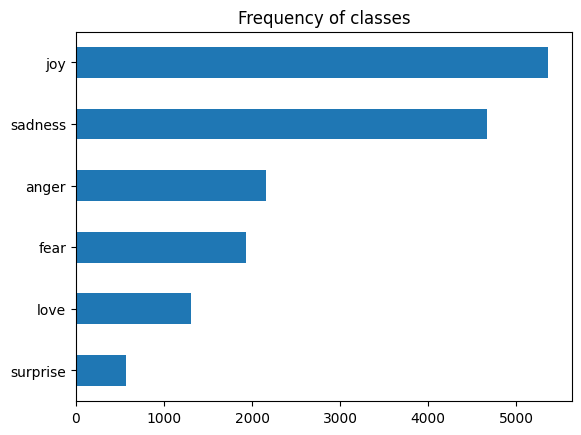

In [13]:
df.label_name.value_counts(ascending=True).plot.barh()
plt.title('Frequency of classes')
plt.show()

For this imbalaced situation is recomendable to balanced the dataset. For now we used the raw data

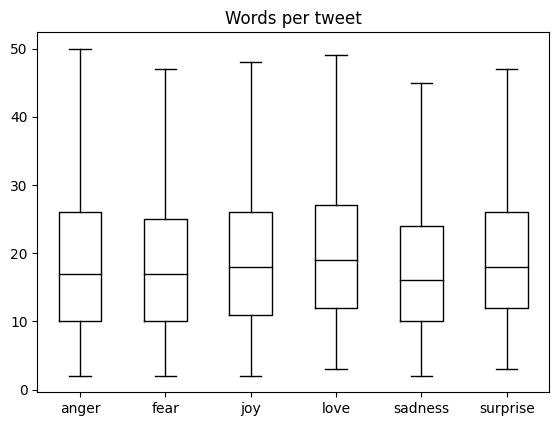

In [14]:
# for now we considering a word as a token

df['Words per tweet'] = df.text.str.split().apply(len)
df.boxplot(
    'Words per tweet', by="label_name", grid=False,
    showfliers=False, color='black'
)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [15]:
# to proceed to make tokens return the original format
emotions.reset_format()

## From text to tokens

#### Character tokenization

In [16]:
## a single tokenization example
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [17]:
## set character toa  unique item
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [18]:
## transform the tokenized text to a list of integers, related with unique id
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [19]:
## creating one hot encoders for tokenizers
import torch
import torch.nn.functional as F

In [21]:
input_ids = torch.tensor(input_ids)
one_hot_encoding = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encoding.shape

torch.Size([38, 20])

In [33]:
# verify that the encode is in the indicated position
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encoding[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

In [34]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


#### Subword tokenization

In [35]:
## bert and distilbert uses WordPiece method to tokenize
from transformers import AutoTokenizer

In [37]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [39]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [40]:
## converting Id's into tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [41]:
## vocabulary size
tokenizer.vocab_size

30522

In [42]:
## max context size
tokenizer.model_max_length

512

#### tokenizing the full dataset

In [43]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [44]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [46]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# there are new columns on the emotions
print(emotions_encoded["train"].column_names)

Loading cached processed dataset at /home/juanxo90/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-f70ea0aba2a29135.arrow
Loading cached processed dataset at /home/juanxo90/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-654bf45943931604.arrow
Loading cached processed dataset at /home/juanxo90/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-878cb527c5d76984.arrow


['text', 'label', 'input_ids', 'attention_mask']


In [50]:
print(emotions_encoded["train"][0])

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
